# 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile

%matplotlib inline

In [2]:
!nvidia-smi

Thu Jul  7 00:56:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8     6W /  N/A |     78MiB /  6144MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dir = "../Data/Classification/10_food_classes_10_percent/train"
test_dir = "../Data/Classification/10_food_classes_10_percent/test"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = "categorical",
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    seed = 42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = "categorical",
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    seed = 42
)

valid_data = test_data.take(int(0.4*len(test_data)))
test_data = test_data.skip(int(0.4*len(test_data)))

len(train_data), len(valid_data), len(test_data)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


(24, 31, 48)

In [5]:
# Create data augmentation layer
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
        tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
    ], name = "data_augmentation_layer"
)

In [6]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
effnetb0 = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
effnetb0.trainable = False
# Now create the model using functional API of tensorflow

# Input layer
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name = "input_layer")

# Data Augmentation layer
x = data_augmentation(inputs)

# EfficientNet Model
x = effnetb0(x, training = False)

# GlobalAveragePool2D
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Dense Layer to finish it off
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation = "softmax", name = "output_layer")(x)

model_baseline = tf.keras.Model(inputs, outputs)

In [8]:
model_baseline.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [9]:
import datetime
def create_tensorboard_callback(base_dir, experiment_name):
    """
    """
    SAVE_DIR = os.path.join(base_dir, experiment_name, datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=SAVE_DIR)
    print(f'Saving TensorBoard logs to path {SAVE_DIR}')
    return tensorboard_callback

In [10]:
# Compile the model
model_baseline.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Fit the model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("Checkpoint/Classification/10_pct_model_weights_exercises/checkpoint.ckpt", save_weights_only=True, save_best_only=False, save_freq="epoch", verbose = 1)

initial_epochs = 5

history_baseline = model_baseline.fit(
    train_data,
    epochs = initial_epochs,
    steps_per_epoch = len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    callbacks = [create_tensorboard_callback("TensorBoard/Classification", "exercises_baseline_model"), checkpoint_callback]
)

Saving TensorBoard logs to path TensorBoard/Classification\exercises_baseline_model\2022_07_07_00_56_44
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.8795 - accuracy: 0.3987 - precision: 1.0000 - recall: 0.0053
Epoch 1: saving model to Checkpoint/Classification/10_pct_model_weights_exercises\checkpoint.ckpt
24/24 [==============================] - 28s 808ms/step - loss: 1.8795 - accuracy: 0.3987 - precision: 1.0000 - recall: 0.0053 - val_loss: 1.3049 - val_accuracy: 0.7560 - val_precision: 0.9890 - val_recall: 0.0907
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2284 - accuracy: 0.7213 - precision: 0.9726 - recall: 0.1893
Epoch 2: saving model to Checkpoint/Classification/10_pct_model_weights_exercises\checkpoint.ckpt
24/24 [==============================] - 16s 671ms/step - loss: 1.2284 - accuracy: 0.7213 - precision: 0.9726 - recall: 0.1893 - val_loss: 0.9142 - val_accuracy: 0.8185 - val_precision: 0.9838 - val_recall: 0.4284
Epoch 3/5
24

In [11]:
results_baseline = model_baseline.evaluate(test_data)
results_baseline

48/48 [==============================] - 6s 105ms/step - loss: 0.6037 - accuracy: 0.8574 - precision: 0.9462 - recall: 0.6877


[0.6036988496780396,
 0.8574270606040955,
 0.9461678862571716,
 0.6876657605171204]

Looks decent but could be better.

In [12]:
history_baseline.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [24]:
def plot_metric_curves(history, figsize = (7,7)):
    """
    """
    history_keys = list(history.history.keys())
    accuracy = history.history[history_keys[1]]
    loss = history.history[history_keys[0]]
    if len(history.history.keys()) > 4:
        precision = history.history[history_keys[2]]
        recall = history.history[history_keys[3]]
        val_accuracy = history.history[history_keys[5]]
        val_loss = history.history[history_keys[4]]
        val_precision = history.history[history_keys[6]]
        val_recall = history.history[history_keys[7]]
    else:  
        val_accuracy = history.history[history_keys[3]]
        val_loss = history.history[history_keys[2]]

    plt.figure(figsize=figsize)
    train_metrics = [accuracy, loss]
    metric_names = ["accuracy", "loss"]
    if len(history.history.keys()) > 4:
        train_metrics = train_metrics + [precision, recall]
        metric_names = metric_names + ["precision", "recall"]
    
    val_metrics = [val_accuracy, val_loss]
    if len(history.history.keys()) > 4:
        val_metrics = val_metrics + [val_precision, val_recall]

    dims = len(history.history.keys())//4
    for i in range(dims):
        for j in range(dims):
            plt.subplot(dims, dims, dims*i + j + 1)
            metric_train = train_metrics[dims*i + j]
            metric_val = val_metrics[dims*i + j]
            plt.plot(range(1, len(metric_train)+ 1), metric_train, label = f"train_{metric_names[dims*i+j]}")
            plt.plot(range(1, len(metric_val)+ 1), metric_val, label = f"val_{metric_names[dims*i+j]}")
            plt.legend()
            plt.title(f"Train and Validation {metric_names[dims*i + j].capitalize()}")

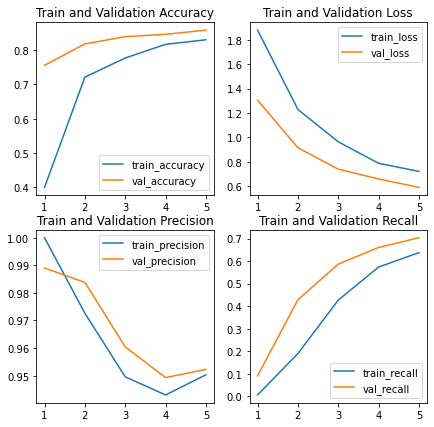

In [16]:
plot_metric_curves(history_baseline)

Looks like we aren't overfitting yet and we could possibly still improve by training over some more epochs. However, lets not and change up the model a bit unfreezing a few layers

## 2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [17]:
for layer_num, layer in enumerate(model_baseline.layers):
    print(f"{layer_num} {layer.name} => {layer.trainable}")

0 input_layer => True
1 data_augmentation_layer => True
2 efficientnetb0 => False
3 global_average_pooling_layer => True
4 output_layer => True


In [20]:
# Lets unfreeze the last 20 layers of the model
effnetb0.trainable = True
for layer in effnetb0.layers[:-20]:
    layer.trainable = False

model_baseline.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model_baseline.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 1,363,770
Non-train

In [21]:
model_baseline.evaluate(test_data)

48/48 [==============================] - 8s 93ms/step - loss: 0.6007 - accuracy: 0.8601 - precision_2: 0.9512 - recall_2: 0.6844


[0.6006824970245361,
 0.8600795865058899,
 0.9511520862579346,
 0.6843501329421997]

In [23]:
fine_tune_epochs = initial_epochs + 5

history_fine_tune_1 = model_baseline.fit(
    train_data,
    epochs = fine_tune_epochs,
    steps_per_epoch = len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    initial_epoch = history_baseline.epoch[-1],
    callbacks = [create_tensorboard_callback("TensorBoard/Classification", "exercises_fine_tuned_model_1")]
)

Saving TensorBoard logs to path TensorBoard/Classification\exercises_fine_tuned_model_1\2022_07_07_01_05_22
Epoch 5/10
24/24 [==============================] - 24s 576ms/step - loss: 0.7616 - accuracy: 0.7440 - precision_2: 0.8309 - recall_2: 0.6747 - val_loss: 0.5261 - val_accuracy: 0.8226 - val_precision_2: 0.8842 - val_recall_2: 0.7621
Epoch 6/10
24/24 [==============================] - 14s 592ms/step - loss: 0.3326 - accuracy: 0.8880 - precision_2: 0.9333 - recall_2: 0.8587 - val_loss: 0.4142 - val_accuracy: 0.8760 - val_precision_2: 0.8977 - val_recall_2: 0.8579
Epoch 7/10
24/24 [==============================] - 13s 536ms/step - loss: 0.1830 - accuracy: 0.9440 - precision_2: 0.9560 - recall_2: 0.9280 - val_loss: 0.5172 - val_accuracy: 0.8458 - val_precision_2: 0.8759 - val_recall_2: 0.8327
Epoch 8/10
24/24 [==============================] - 13s 519ms/step - loss: 0.1125 - accuracy: 0.9627 - precision_2: 0.9714 - recall_2: 0.9520 - val_loss: 0.5353 - val_accuracy: 0.8579 - val_pre

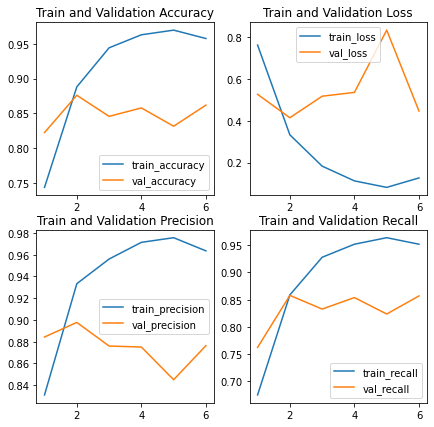

In [25]:
plot_metric_curves(history_fine_tune_1)

Yeah, this is where we've gone overboard by overfitting to the data. One reason is that we've got barely 75 images per class since the data is shorted out.

## 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [26]:
model_baseline.load_weights("Checkpoint/Classification/10_pct_model_weights_exercises/checkpoint.ckpt")
model_baseline.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [27]:
model_baseline.evaluate(test_data)

48/48 [==============================] - 32s 564ms/step - loss: 0.6045 - accuracy: 0.8568 - precision_3: 0.9475 - recall_3: 0.6817


[0.6044965982437134,
 0.8567638993263245,
 0.9474654197692871,
 0.6816976070404053]

In [29]:
effnetb0.trainable = True
for layer in effnetb0.layers[:-30]:
    layer.trainable = False

model_baseline.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model_baseline.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 1,508,970
Non-train

In [30]:
history_fine_tune_2 = model_baseline.fit(
    train_data,
    epochs = fine_tune_epochs,
    steps_per_epoch = len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    initial_epoch = history_baseline.epoch[-1],
    callbacks = [create_tensorboard_callback("TensorBoard/Classification", "exercises_fine_tuned_model_2")]
)

Saving TensorBoard logs to path TensorBoard/Classification\exercises_fine_tuned_model_2\2022_07_07_01_20_56
Epoch 5/10
24/24 [==============================] - 86s 3s/step - loss: 0.7280 - accuracy: 0.7627 - precision_4: 0.8541 - recall_4: 0.6947 - val_loss: 0.4391 - val_accuracy: 0.8639 - val_precision_4: 0.8943 - val_recall_4: 0.8357
Epoch 6/10
24/24 [==============================] - 63s 3s/step - loss: 0.3262 - accuracy: 0.8867 - precision_4: 0.9136 - recall_4: 0.8600 - val_loss: 0.4279 - val_accuracy: 0.8669 - val_precision_4: 0.8891 - val_recall_4: 0.8488
Epoch 7/10
24/24 [==============================] - 63s 3s/step - loss: 0.1377 - accuracy: 0.9693 - precision_4: 0.9835 - recall_4: 0.9560 - val_loss: 0.5787 - val_accuracy: 0.8508 - val_precision_4: 0.8609 - val_recall_4: 0.8357
Epoch 8/10
24/24 [==============================] - 65s 3s/step - loss: 0.1474 - accuracy: 0.9560 - precision_4: 0.9583 - recall_4: 0.9507 - val_loss: 0.4609 - val_accuracy: 0.8679 - val_precision_4: 0.

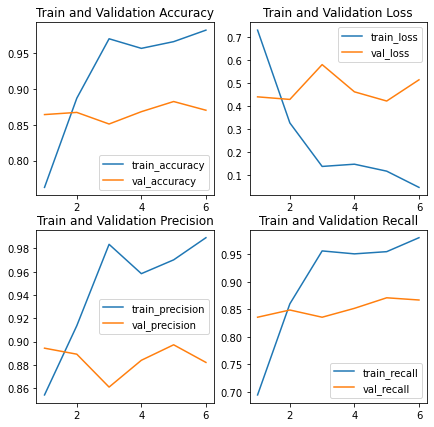

In [31]:
plot_metric_curves(history_fine_tune_2)

Even before we started this experiment we knew that we were certainly going to overfit. And this is observable from the graphs

## 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [44]:
import random
def predict_and_visualise(model, base_dir, class_names = train_data.class_names, figsize = (7,7)):
    """
    """
    # Set the directory (train/test)
    dataset = random.choice(os.listdir(base_dir))
    class_name = random.choice(os.listdir(f"{base_dir}/{dataset}"))
    image_name = random.choice(os.listdir(f'{base_dir}/{dataset}/{class_name}'))
    img = mpimg.imread(f'{base_dir}/{dataset}/{class_name}/{image_name}')
    img_tensor = tf.expand_dims(img, axis = 0)
    img_tensor_reshape = tf.keras.layers.experimental.preprocessing.Resizing(224,224)(img_tensor)
    prediction = tf.argmax(model_baseline.predict(img_tensor_reshape), axis = 1)[0]
    prediction_label = class_names[prediction]
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis(False)
    if class_name == prediction_label:
        plt.title(f"Actual Label: {class_name}\nPredicted Label: {prediction_label}", color = "green")
    else:
        plt.title(f"Actual Label: {class_name}\nPredicted Label: {prediction_label}", color = "return")
    return

1/1 [==============================] - 0s 42ms/step


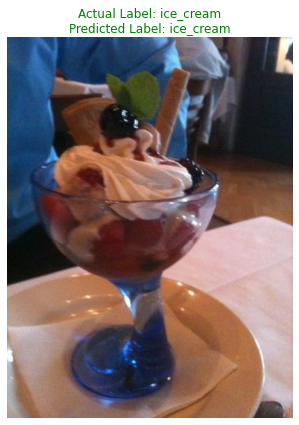

In [45]:
predict_and_visualise(model_baseline, "../Data/Classification/10_food_classes_10_percent")

Good stuff! This brings us to the end of transfer learning I guess.